<a href="https://colab.research.google.com/github/jgait/DSPS_WGaither/blob/main/HW10/MckennedyGaitherPINN_Burgers_tofillinipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
tf.__version__

'2.14.0'

In [ ]:
import scipy
from scipy import io
from scipy.interpolate import griddata
import pylab as pl

In [ ]:
!wget https://github.com/maziarraissi/PINNs/raw/master/appendix/Data/burgers_shock.mat

--2023-12-12 00:33:20--  https://github.com/maziarraissi/PINNs/raw/master/appendix/Data/burgers_shock.mat
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/maziarraissi/PINNs/master/appendix/Data/burgers_shock.mat [following]
--2023-12-12 00:33:20--  https://raw.githubusercontent.com/maziarraissi/PINNs/master/appendix/Data/burgers_shock.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 207944 (203K) [application/octet-stream]
Saving to: ‘burgers_shock.mat’

burgers_shock.mat   100%[===================>] 203.07K  --.-KB/s    in 0.01s   

2023-12-12 00:33:20 (17.4 MB/s) - ‘burgers_shock.mat’ saved

(100,) (256,) (256, 100)


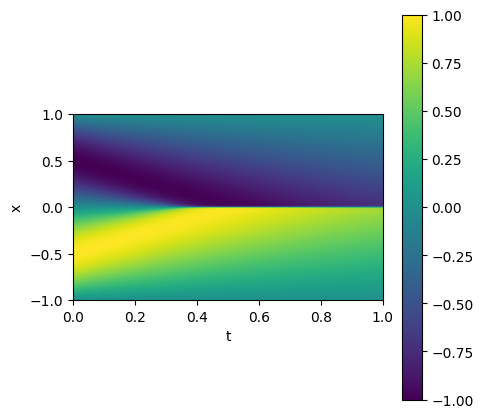

In [ ]:
### what is the solution that we want? read in the data

# loading in a file saved as a binary (?) in mathematica
data = scipy.io.loadmat('burgers_shock.mat')

data.keys()

t = data['t'].flatten() #time
x = data['x'].flatten() #position
Z = np.real(data['usol']) #solution of Burger's Ee

print(t.shape, x.shape, Z.shape)

ax = pl.figure(figsize=(5,5)).add_subplot(111)
cb = ax.imshow(Z[::-1],extent=[0,1,-1,1], clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3)
pl.colorbar(cb);


**Figure 1:** Plot of the solution of Burger's equations, using physically constrained nueral networks this notebook will try to replicate this.

# PROBLEM SETUP: BURGER'S EQUATIONS
$$
\begin{align}
    \partial_t u (t,x) + \mathcal{N}[u](t,x) &= 0, && (t,x) \in (0,T] \times \mathcal{D},\\
    u(0,x) &= u_0(x) \quad && x \in \mathcal{D},
\end{align}
$$


$$
\begin{align}
        \hspace{7em} u(t,x) &= u_b(t,x)  && \quad (t,x) \in (0,T] \times \partial \mathcal{D},
\end{align}
$$


# SPECIFIC CASE: LIMIT REGIME AND SET VISCOSITY TO $\nu=0.01/\pi$

$$
\begin{aligned}
    \partial_t u + u \, \partial_x u - (0.01/\pi) \, \partial_{xx} u &= 0, \quad &&\quad (t,x) \in (0,1] \times (-1,1),&&\mathrm{eq.1}\\
   u(0,x) &= - \sin(\pi \, x),                 \quad &&\quad x \in [-1,1],&\mathrm{eq.2}\\
   u(t,-1) = u(t,1) &= 0,                      \quad &&\quad t \in (0,1].
\end{aligned}
$$

In [ ]:
tf.random.set_seed(123)
pi = tf.constant(np.pi, dtype="float32")

In [ ]:
def fun_u_0(x): #u(0,x) eq 2
  return -tf.sin(pi * x)

def fun_u_b(t, x): #u(t,x) - set up container
  return tf.zeros((x.shape[0], 1), dtype="float32")

def fun_res(u, u_t, u_x, u_xx): #deruvatuve equation eq 1 - u_. is the derivative w respect to .
  return tf.abs(u_t + u * u_x - 0.01 / pi * u_xx)

In [ ]:
#number of points we are using for training and predicting
n_0 = 50 #points at t=0 -> initial conditions
n_b = 50 #points at b=1;-1] -> boundary conditions
n_r = 10000

#boundaries
tmin = 0.
tmax = 1.
xmin = -1.
xmax = 1.

# get random data in x at t=0


In [ ]:
t_0 = tf.ones((n_0, 1), dtype="float32") * tmin
x_0 = tf.random.uniform((n_0, 1), xmin, xmax, dtype="float32")
X_0 = tf.concat([t_0, x_0], axis=1)
X_0

<tf.Tensor: shape=(50, 2), dtype=float32, numpy=
array([[ 0.        , -0.7476938 ],
       [ 0.        ,  0.14550257],
       [ 0.        , -0.4013734 ],
       [ 0.        ,  0.09236717],
       [ 0.        ,  0.44103146],
       [ 0.        ,  0.5779066 ],
       [ 0.        , -0.3846376 ],
       [ 0.        , -0.03657794],
       [ 0.        ,  0.30755043],
       [ 0.        , -0.7580149 ],
       [ 0.        , -0.27416515],
       [ 0.        , -0.5102    ],
       [ 0.        , -0.54608774],
       [ 0.        ,  0.04020071],
       [ 0.        ,  0.7369325 ],
       [ 0.        , -0.42762113],
       [ 0.        , -0.01630592],
       [ 0.        ,  0.34997678],
       [ 0.        , -0.11965895],
       [ 0.        , -0.02140164],
       [ 0.        ,  0.6112704 ],
       [ 0.        ,  0.7948568 ],
       [ 0.        ,  0.27323198],
       [ 0.        ,  0.00240111],
       [ 0.        , -0.03221846],
       [ 0.        ,  0.50451255],
       [ 0.        ,  0.6129718 ],
      

# evaluate initial condition at x_0

In [ ]:
u_0 = fun_u_0(x_0) #eq 2
u_0

<tf.Tensor: shape=(50, 1), dtype=float32, numpy=
array([[ 0.7122112 ],
       [-0.44135648],
       [ 0.95238096],
       [-0.28612474],
       [-0.9828893 ],
       [-0.97019774],
       [ 0.93504095],
       [ 0.11466026],
       [-0.8227306 ],
       [ 0.6890799 ],
       [ 0.7587001 ],
       [ 0.9994866 ],
       [ 0.9895364 ],
       [-0.12595879],
       [-0.7355314 ],
       [ 0.97425926],
       [ 0.05120417],
       [-0.89097345],
       [ 0.36712813],
       [ 0.0671846 ],
       [-0.9395213 ],
       [-0.60077995],
       [-0.756787  ],
       [-0.00754325],
       [ 0.10104453],
       [-0.9998995 ],
       [-0.9376773 ],
       [ 0.06082507],
       [ 0.49481562],
       [-0.48312566],
       [ 0.94241977],
       [-0.5245297 ],
       [-0.8038826 ],
       [ 0.8135314 ],
       [-0.8391674 ],
       [-0.85155034],
       [-0.9423501 ],
       [ 0.77795136],
       [ 0.5914944 ],
       [ 0.09085801],
       [ 0.49529788],
       [ 0.4755419 ],
       [ 0.01998235],
     

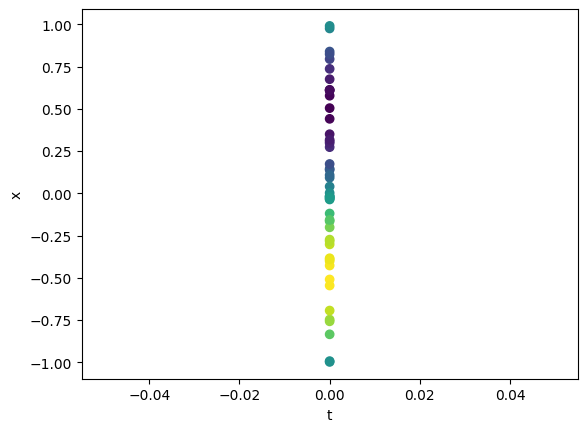

In [ ]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

**Figure 2:** Boundary conditions of Burgers equations (t=0).

# get data at boundaries of x at random t's



In [ ]:
t_b = tf.random.uniform((n_b, 1), tmin, tmax, dtype="float32")
x_b = xmin + (xmax - xmin) * tf.keras.backend.random_bernoulli((n_b, 1), 0.5, dtype="float32")
X_b = tf.concat([t_b, x_b], axis=1)
X_b

<tf.Tensor: shape=(50, 2), dtype=float32, numpy=
array([[ 0.88968754, -1.        ],
       [ 0.12354946,  1.        ],
       [ 0.7718717 ,  1.        ],
       [ 0.6850728 , -1.        ],
       [ 0.6442598 ,  1.        ],
       [ 0.07745004,  1.        ],
       [ 0.75058556,  1.        ],
       [ 0.6250843 ,  1.        ],
       [ 0.00772953,  1.        ],
       [ 0.55370283, -1.        ],
       [ 0.83894694, -1.        ],
       [ 0.43658102,  1.        ],
       [ 0.9566101 , -1.        ],
       [ 0.7588576 , -1.        ],
       [ 0.8964343 ,  1.        ],
       [ 0.44467843, -1.        ],
       [ 0.3243779 , -1.        ],
       [ 0.3443855 , -1.        ],
       [ 0.91262174,  1.        ],
       [ 0.77731085,  1.        ],
       [ 0.899588  , -1.        ],
       [ 0.50426483, -1.        ],
       [ 0.45032525, -1.        ],
       [ 0.5939442 , -1.        ],
       [ 0.71862614, -1.        ],
       [ 0.91657436, -1.        ],
       [ 0.98180914, -1.        ],
      

# evaluate data at boundaries of x at random t's


In [ ]:
u_b = fun_u_b(t_b, x_b)
u_b

<tf.Tensor: shape=(50, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)>

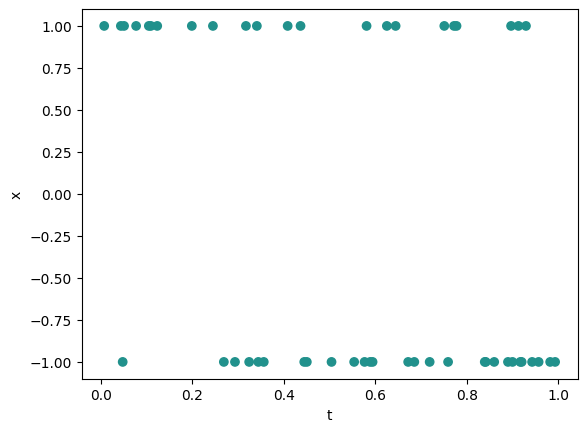

In [ ]:
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

**Figure 3:** Top and Bottom boundary conditions (x=-1, x=1)

# get points inside the space at random where the function will be predicted

In [ ]:
t_r = tf.random.uniform((n_r, 1), tmin, tmax, dtype="float32")
x_r = tf.random.uniform((n_r, 1), xmin, xmax, dtype="float32")
X_r = tf.concat([t_r, x_r], axis=1)
X_r

<tf.Tensor: shape=(10000, 2), dtype=float32, numpy=
array([[ 0.48962688, -0.15719008],
       [ 0.5857923 ,  0.16138387],
       [ 0.36451697, -0.43461084],
       ...,
       [ 0.9338294 ,  0.9995079 ],
       [ 0.11166203, -0.28287673],
       [ 0.00506091,  0.7726338 ]], dtype=float32)>

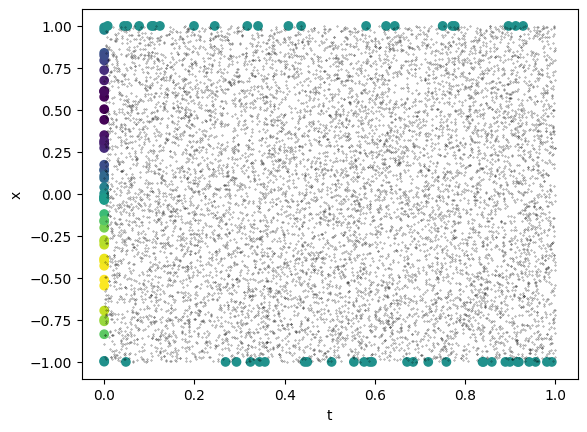

In [ ]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.scatter(t_r, x_r, c="k", marker='.', s=0.3, alpha=0.7, clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

**Figure 4:** This is the plot with the initial conditions and 10,000 randomly generated points plotted within those bounds.

In [ ]:
#put boundary conditionns together
X = tf.concat([X_0, X_b], axis=0)
y = tf.concat([u_0, u_b], axis=0)
X.shape, y.shape


(TensorShape([100, 2]), TensorShape([100, 1]))

# create the model with simple loss

In [ ]:
nnmodel = tf.keras.Sequential()

#input layer with 2 neurons for 2 dimensions
nnmodel.add(tf.keras.layers.InputLayer(input_shape=(2,)))

#8 hidden layers
for i in range(8):
    nnmodel.add(tf.keras.layers.Dense(16, activation='relu'))

#output layer is 1D
nnmodel.add(tf.keras.layers.Dense(1, activation='linear'))


In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001)

def custom_loss_1(u_true, u_pred):
  return tf.reduce_mean(tf.square(u_true - u_pred)) # L2 Loss

In [ ]:
nnmodel.compile(loss=custom_loss_1, optimizer=optim)

In [ ]:
nnmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                48        
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)             (None, 16)                272       
                                                                 
 dense_6 (Dense)             (None, 16)                2

## train the model

In [ ]:
history = nnmodel.fit(X, y, epochs=1000)

Epoch 1/1000
4/4 [==============================] - 7s 10ms/step - loss: 0.2236
Epoch 2/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.2202
Epoch 3/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.2169
Epoch 4/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.2133
Epoch 5/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.2089
Epoch 6/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.2035
Epoch 7/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.1976
Epoch 8/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.1919
Epoch 9/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.1858
Epoch 10/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1812
Epoch 11/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1752
Epoch 12/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1701
Epoch 13/1000
4/4 [=============================

Text(0, 0.5, 'loss')

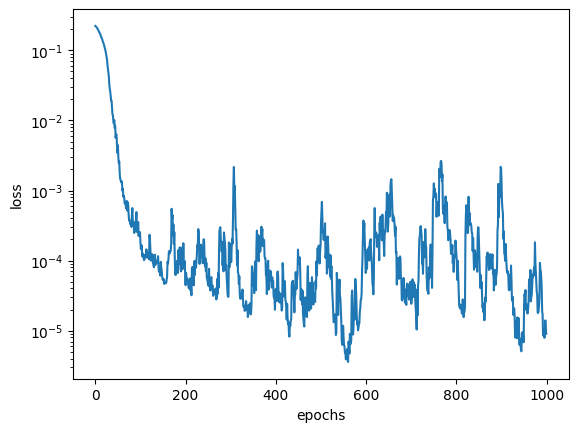

In [ ]:
pl.semilogy(history.history["loss"])
pl.xlabel("epochs")
pl.ylabel("loss")

**Figure 5:** For the first 100 epochs it looks absolutely great, Based on what we learned in class I'm guessing the noise is not a problem with the learing rate since its not diverging, but rather just because we have not implemented the Physical Modeling constraints to the neural net.

## see the result

In [ ]:
nnmodel.predict(tf.concat([t_r, x_r], axis=1))

313/313 [==============================] - 1s 3ms/step


array([[ 2.4447840e-01],
       [ 2.8102514e-01],
       [ 4.8242390e-01],
       ...,
       [ 4.2810291e-04],
       [ 8.1762367e-01],
       [-6.1481935e-01]], dtype=float32)

313/313 [==============================] - 1s 3ms/step


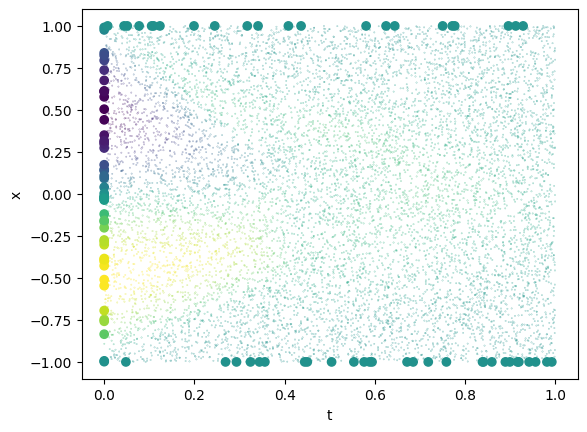

In [ ]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.scatter(t_r, x_r, c=nnmodel.predict(tf.concat([t_r, x_r], axis=1)), marker='.',
           s=0.2, alpha=0.7, clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

**Figure 6:** Our current models predictions of the results of Burgers equations based on the initial conditions. As you can see it actually does surprisingly well, however nearing the right side it seems to be more and more off because the averaging of the top and bottom initial conditions of 0 slowly diverging the model away from the t=0 initial condition.

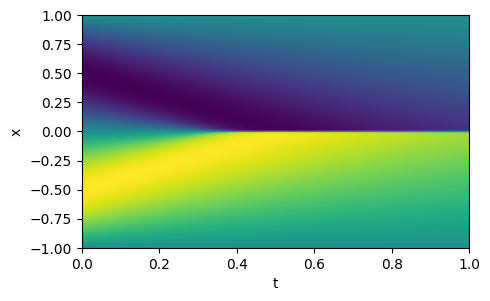

In [ ]:
ax = pl.figure(figsize=(5,5)).add_subplot(111)
cb = ax.imshow(Z[::-1],extent=[0,1,-1,1], clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3);


**Figure 7:** Once again the solution to Burger's equation to compare with the results of the model above.

show the accuracy for every point that you solved for

8/8 [==============================] - 0s 2ms/step


38.954774097204066

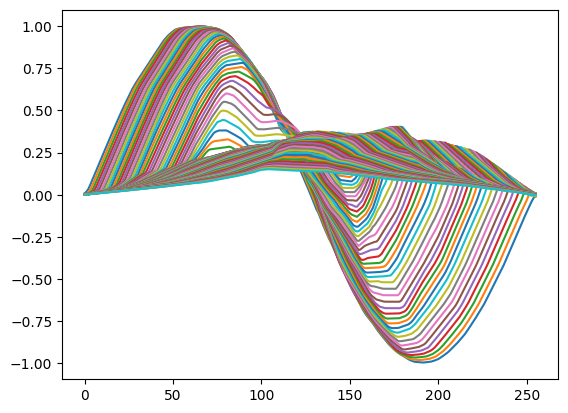

In [ ]:
def L1accuracy(t, x, model):
  tmp_ = np.zeros((x.shape[0], 2), dtype="float32")
  tmp_[:,1] += x
  acc = 0
  for tt in range(t.shape[0]):
    tmp_[:,0] = t[tt]
    pl.plot(model.predict(tmp_))
    acc += (model.predict(tmp_) - Z[:,tt]).sum()


  return acc / np.prod(t.shape[0] * x.shape[0])
L1accuracy(t, x, nnmodel)

**Figure 8:** I'm honestly not really sure what this means.

8/8 [==============================] - 0s 3ms/step


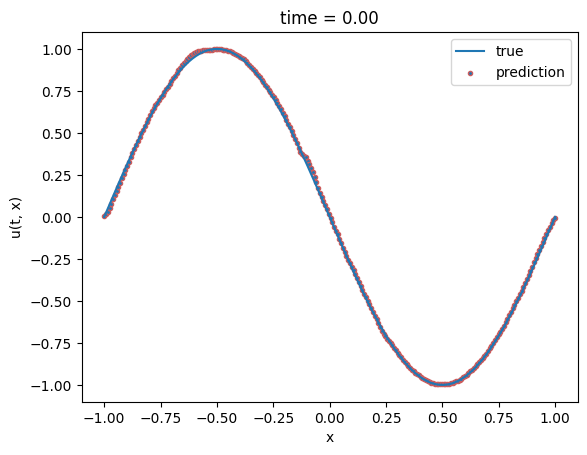

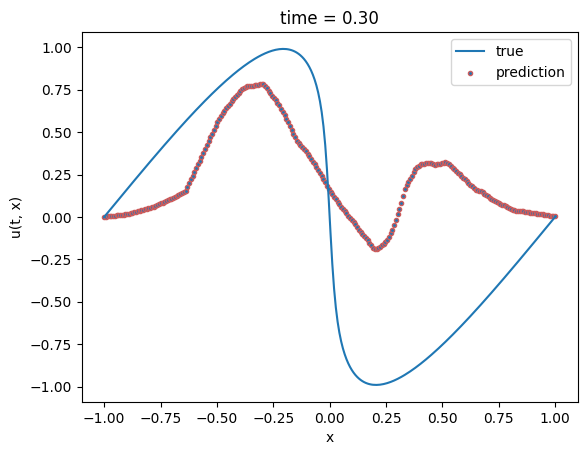

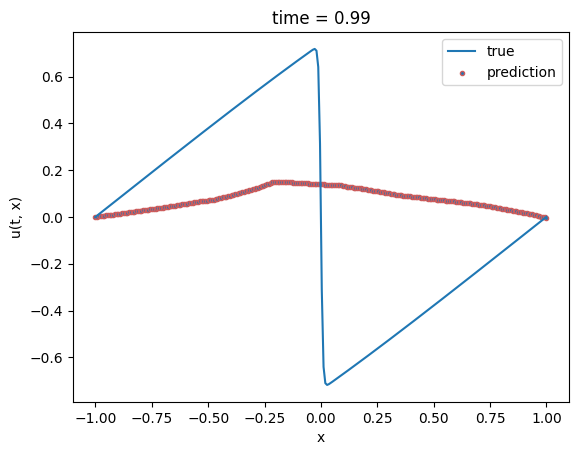

In [ ]:
tmp_ = np.zeros((x.shape[0], 2), dtype="float32")
tmp_[:,1] += x
inds = [0, 30, -1]
for i in range(3):
  pl.figure()
  pl.title("time = %.2f"%t[inds[i]])
  pl.plot(x, Z[:,inds[i]], label="true")
  tmp_[:,0] = t[inds[i]]
  pl.scatter(x, nnmodel.predict(tmp_), marker='.', edgecolors="IndianRed",
             label="prediction")
  pl.xlabel("x")
  pl.ylabel("u(t, x)")
  pl.legend();


**Figure 9:** These plots show the true vs predicted values for different times, the model is trying its best but its clear to see that its not very accurate.

# create the model with complete loss

In [ ]:
def get_pde(model, X_r):

  with tf.GradientTape(persistent=True) as tape:
      t, x = X_r[:,0:1], X_r[:,1:2]
      tape.watch(t)
      tape.watch(x)
      u = model(tf.concat([t, x], axis=1))
      u_x = tape.gradient(u,x)
      #print(u_x)
  u_t = tape.gradient(u, t)
  u_xx = tape.gradient(u_x, x)

  del tape # to save some memory

  return u, u_t, u_x, u_xx


In [ ]:
def custom_loss(model, X_r, X, y):
    u, u_t, u_x, u_xx = get_pde(model, X_r)
    PDE = fun_res(u, u_t, u_x, u_xx)

    return tf.reduce_mean(tf.square(PDE)) + custom_loss_1(y, model(X))


In [ ]:
def get_grad(model, X_r, X, y):
    # model derivatives for backprop

    # Got some chatGPT help for this part
    # Use GradientTape to compute gradients
    with tf.GradientTape(persistent=True) as tape:
      # Watch the input and model trainable variables
      tape.watch(model.trainable_variables)

      # Compute custom loss (Complete loss)
      loss = custom_loss(model, X_r, X, y)

    g = tape.gradient(loss, model.trainable_variables)
    del tape
    return loss, g

## train the model

In [ ]:
import copy

In [ ]:
pinn = tf.keras.Sequential()

#input layer with 2 neurons for 2 dimensions
pinn.add(tf.keras.layers.InputLayer(input_shape=(2,)))
#hidden layers
for i in range(8):
  # RELU DID NOT WORK VERY WELL
  pinn.add(tf.keras.layers.Dense(16, activation='tanh'))
#output layer is 1D
pinn.add(tf.keras.layers.Dense(1, activation='linear'))

In [ ]:
@tf.function
def train_step(model, X_r, X, y):

  loss, grad = get_grad(model, X_r, X, y)
  optim.apply_gradients(zip(grad, model.trainable_variables))
  return loss

optim = tf.keras.optimizers.Adam(learning_rate=0.005)
pinn.compile(loss=custom_loss, optimizer=optim) #change the loss and optimization

history = []
Nepochs = 5000
for i in range(Nepochs):
  loss = train_step(pinn, X_r, X, y)
  history.append(loss.numpy())
  # Output current loss after 50 iterates
  if i%50 == 0:
    print(f'It {i:05d}: loss = {loss:10.8e}')



It 00000: loss = 2.88243473e-01
It 00050: loss = 1.16808400e-01
It 00100: loss = 8.67941305e-02
It 00150: loss = 7.55864903e-02
It 00200: loss = 6.78173453e-02
It 00250: loss = 5.82315400e-02
It 00300: loss = 5.42205423e-02
It 00350: loss = 5.10094054e-02
It 00400: loss = 5.13483658e-02
It 00450: loss = 4.76350598e-02
It 00500: loss = 3.90045978e-02
It 00550: loss = 8.53756219e-02
It 00600: loss = 2.03644745e-02
It 00650: loss = 3.05667557e-02
It 00700: loss = 1.38888899e-02
It 00750: loss = 2.15316024e-02
It 00800: loss = 1.04066897e-02
It 00850: loss = 9.69671551e-03
It 00900: loss = 5.70203830e-03
It 00950: loss = 5.95989125e-03
It 01000: loss = 5.75485267e-03
It 01050: loss = 3.56390397e-03
It 01100: loss = 1.07066156e-02
It 01150: loss = 2.95882626e-03
It 01200: loss = 3.35412798e-03
It 01250: loss = 2.26531457e-03
It 01300: loss = 1.97555614e-03
It 01350: loss = 1.81158190e-03
It 01400: loss = 1.95107865e-03
It 01450: loss = 6.31460361e-03
It 01500: loss = 1.50654709e-03
It 01550

313/313 [==============================] - 1s 2ms/step


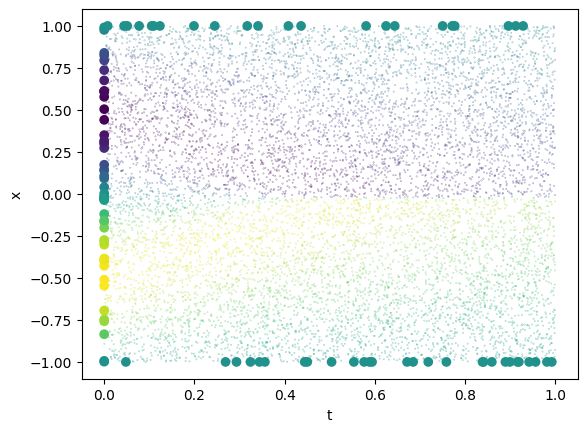

In [ ]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)), marker='.',
           s=0.2, alpha=0.7, clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

**Figure 10:** Predictions for Burger's equation with the new model, this matches way closer than the last one. For some reason though on the last one I got amazing results with the ReLu activation function on the dense layers, but on this one I had to use Tanh to get good results.

313/313 [==============================] - 1s 2ms/step


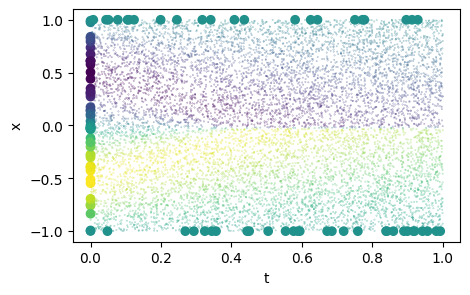

In [ ]:
ax = pl.figure(figsize=(5,5)).add_subplot(111)
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
ax.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
ax.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)),
           marker='.', s=0.2, alpha=0.7, clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");
ax.set_aspect(0.3);

**Figure 11:** Smaller version of figure 10, just includes the boundary conditions.

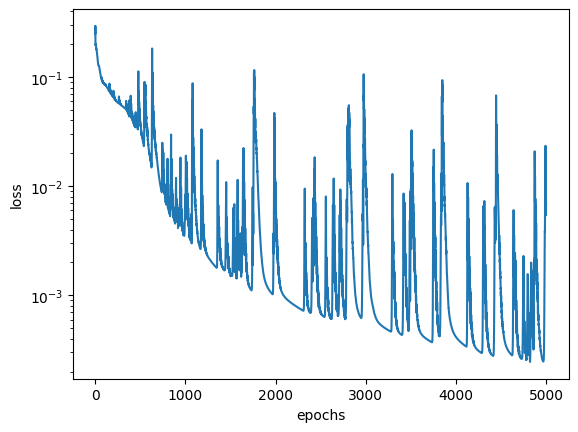

In [ ]:
pl.semilogy(history)
pl.xlabel("epochs")
pl.ylabel("loss");

**Figure 12:** Loss is still noisy, but not diverging so I think that it is fine.

8/8 [==============================] - 0s 2ms/step


-6.162777139116243

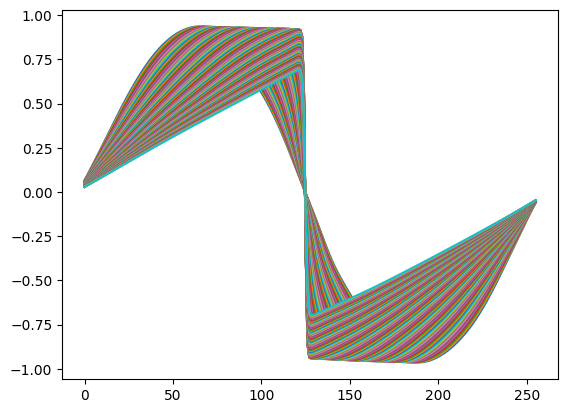

In [ ]:
L1accuracy(t, x, pinn)

**Figure 13:** Still not exactly sure what this means, I guess the lines being more tightly packed shows a better coorlation between adjacent times showing which represents the much better fit.

# adjust the learning rate and trin some more
the loss was awfully noisy

In [ ]:
from tensorflow.keras.backend import set_value
set_value(pinn.optimizer.lr, 0.0001)

In [ ]:
Nepochs = 10000
for i in range(Nepochs):
  loss = train_step(pinn, X_r, X, y)
  history.append(loss.numpy())
  # Output current loss after 50 iterates
  if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))


It 00000: loss = 1.09747089e-02
It 00050: loss = 1.68727222e-03
It 00100: loss = 1.10529514e-03
It 00150: loss = 8.13410850e-04
It 00200: loss = 6.54970529e-04
It 00250: loss = 5.55046136e-04
It 00300: loss = 4.91265673e-04
It 00350: loss = 4.34939808e-04
It 00400: loss = 3.91550187e-04
It 00450: loss = 3.62987863e-04
It 00500: loss = 3.41482897e-04
It 00550: loss = 3.24109977e-04
It 00600: loss = 3.09752388e-04
It 00650: loss = 2.97729712e-04
It 00700: loss = 2.87567993e-04
It 00750: loss = 2.78909749e-04
It 00800: loss = 2.71481113e-04
It 00850: loss = 2.65067851e-04
It 00900: loss = 2.59502151e-04
It 00950: loss = 2.54637882e-04
It 01000: loss = 2.50364217e-04
It 01050: loss = 2.46587850e-04
It 01100: loss = 2.43224975e-04
It 01150: loss = 2.40218156e-04
It 01200: loss = 2.37509157e-04
It 01250: loss = 2.35055515e-04
It 01300: loss = 2.32813298e-04
It 01350: loss = 2.30757258e-04
It 01400: loss = 2.28860416e-04
It 01450: loss = 2.27097626e-04
It 01500: loss = 2.25451018e-04
It 01550

Text(0, 0.5, 'loss')

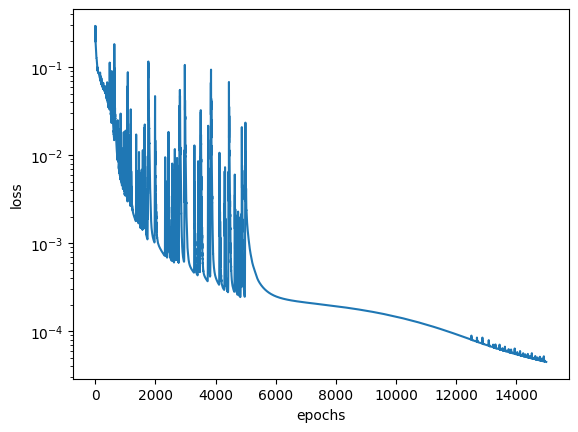

In [ ]:
pl.semilogy(history)
pl.xlabel("epochs")
pl.ylabel("loss")

**Figure 14:** Lowering the learning rate really reduced the noise at the tail of this loss graph, it could potentially be lowered even more because the small noise bumps near the end.

313/313 [==============================] - 1s 3ms/step


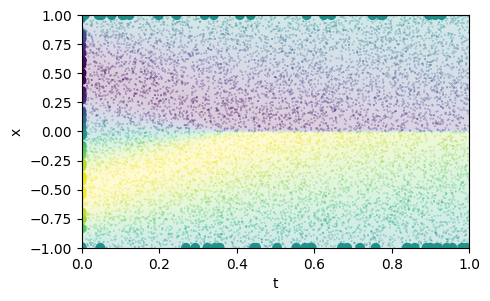

In [ ]:
ax = pl.figure(figsize=(5,5)).add_subplot()
ax.imshow(Z[::-1],extent=[0,1,-1,1], alpha=0.2)
ax.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
ax.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
ax.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)),
           marker='.', s=0.2, alpha=0.7, clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3);

**Figure 16:** Even better than the results from Figure 10.

In [ ]:
Nepochs = 10000
for i in range(Nepochs):
  loss = train_step(pinn, X_r, X, y)
  history.append(loss.numpy())
  # Output current loss after 50 iterates
  if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

It 00000: loss = 4.50240477e-05
It 00050: loss = 4.58162758e-05
It 00100: loss = 4.42336459e-05
It 00150: loss = 4.40739313e-05
It 00200: loss = 4.34532594e-05
It 00250: loss = 4.56822600e-05
It 00300: loss = 4.27262530e-05
It 00350: loss = 4.23407473e-05
It 00400: loss = 4.23008751e-05
It 00450: loss = 4.16396360e-05
It 00500: loss = 4.12910376e-05
It 00550: loss = 4.13679882e-05
It 00600: loss = 4.06235777e-05
It 00650: loss = 4.02956030e-05
It 00700: loss = 4.01268298e-05
It 00750: loss = 3.96709875e-05
It 00800: loss = 4.05836763e-05
It 00850: loss = 3.91751564e-05
It 00900: loss = 3.87651889e-05
It 00950: loss = 3.84642844e-05
It 01000: loss = 4.04743987e-05
It 01050: loss = 3.78826844e-05
It 01100: loss = 3.86263855e-05
It 01150: loss = 3.73300936e-05
It 01200: loss = 3.70495254e-05
It 01250: loss = 3.73694202e-05
It 01300: loss = 3.65184424e-05
It 01350: loss = 3.62696992e-05
It 01400: loss = 3.60672348e-05
It 01450: loss = 4.17394040e-05
It 01500: loss = 3.55175289e-05
It 01550

Text(0, 0.5, 'loss')

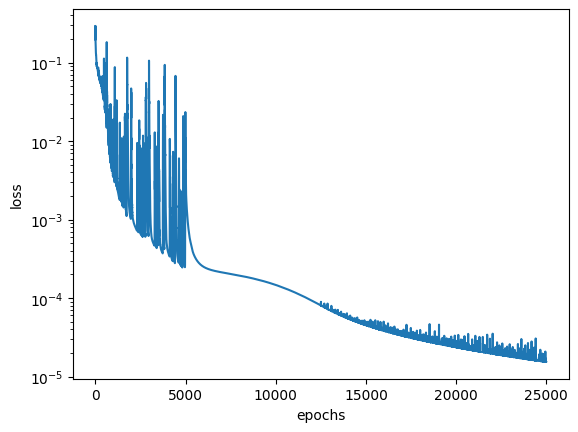

In [ ]:
pl.semilogy(history)
pl.xlabel("epochs")
pl.ylabel("loss")

**Figure 16:** Converges much faster, noise looks worse but when you compare the y axis ranges it is much smaller than the last graph.

## final result

8/8 [==============================] - 0s 2ms/step


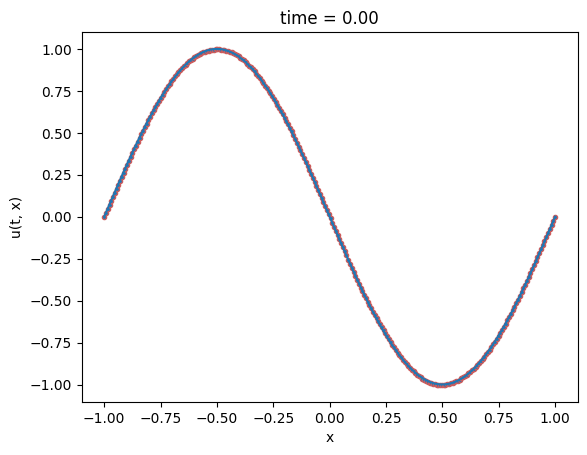

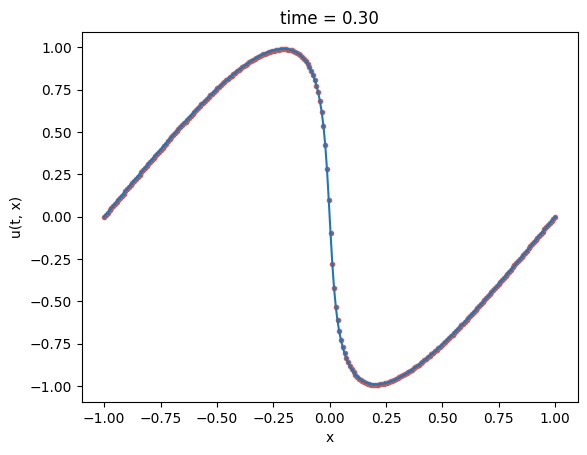

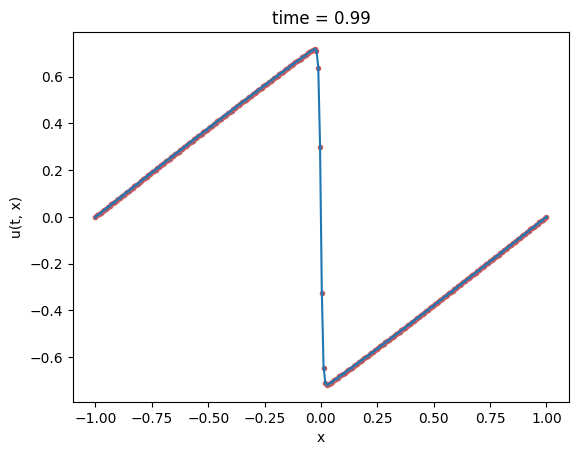

In [ ]:
for i in range(3):
  pl.figure()
  pl.title("time = %.2f"%t[inds[i]])
  pl.plot(x, Z[:,inds[i]])
  tmp_[:,0] = t[inds[i]]
  pl.scatter(x, pinn.predict(tmp_), marker='.', edgecolors="IndianRed")
  pl.xlabel("x")
  pl.ylabel("u(t, x)");

**Figure 17** AMAZING! the NN predicts nearly exactly the solutions on all 3 cases, unlike the earlier model.

313/313 [==============================] - 1s 2ms/step


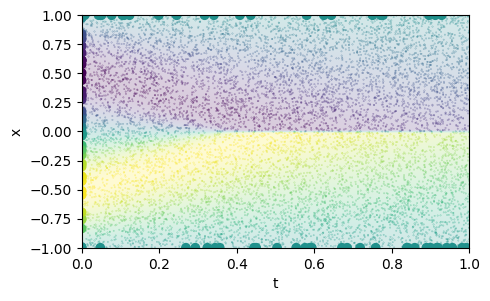

In [ ]:
ax = pl.figure(figsize=(5,5)).add_subplot(111)
ax.imshow(Z[::-1], extent=[0,1,-1,1], alpha=0.2)
ax.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
ax.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
ax.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)),
           marker='.', s=0.2, alpha=0.7, clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3)
#pl.colorbar();

**Figure 18:** Final plot of the models results, looks virtually identical to the real solutions to Burger's Equations that it was trained on.

8/8 [==============================] - 0s 3ms/step


-0.11573454467596225

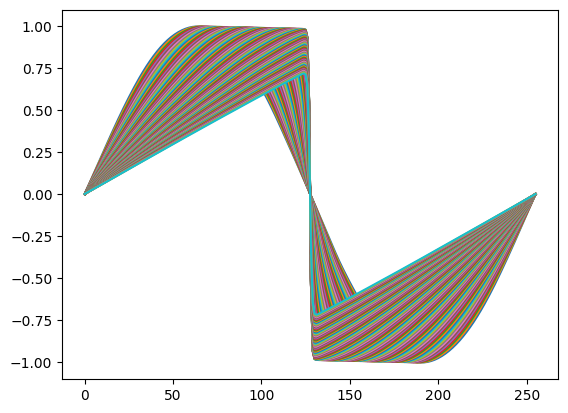

In [ ]:
L1accuracy(t, x, pinn)

**Figure 19:** Again i'm not sure what this means exactly, but it is quite similar to the last one with tightly, highly coorelated lines which i believe represents the convergance on Burger's equations.